In [11]:
# Importe
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
import matplotlib.pyplot as plt
from itertools import product


# Die Klasse macht aus Numpy-Daten (X_train_seq, y_train) ein PyTorch kompatibles Dataset
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
            return len(self.X)

    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [12]:
# Unser Attention-Mechanismus

class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Sequential(                       # Ein kleines nn, das einen Score für diesen Zeitschritt angibt (Wie wichtig?)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_outputs):
        # lstm_outputs: (batch, seq_len, hidden)
        attn_scores = self.attn(lstm_outputs)              # Jeden Zeitschritt eine Zahl, wie wichtig es ist
        attn_weights = torch.softmax(attn_scores, dim=1)   # In Prozente umwandeln, die sich zu 1 addieren
        context = torch.sum(attn_weights * lstm_outputs, dim=1)  # (batch, hidden)
        return context, attn_weights.squeeze(-1)

In [13]:
# LSTM-Modell Klasse

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.0001, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        self.attention = AttentionMechanism(hidden_size)

        # Wir kombinieren: [LSTM_output_last ; Attention_context]
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    
    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        # gibt gesamte Sequenz und letzten state zurück
        out, (hn, cn) = self.lstm(x, (h0, c0))       # out: (batch, seq_len, hidden)
        context, attn_weights = self.attention(out)  # (batch, hidden)

        # hn[-1] = letzter hidden state der letzten LSTM-Schicht (klassisch)
        lstm_output = hn[-1]  # (batch, hidden)

        # Bypass-Mechanismus
        combined = torch.cat((lstm_output, context), dim=1)  # (batch, hidden*2)

        out = self.fc(combined)
        return out, attn_weights

    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        
    
    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen
            total_test_loss = 0
            with torch.no_grad():  # keine Gradienten beim Testen
                for batch in test_loader:
                    loss = self.test_step(batch)  # oder self.train_step(batch) im eval-Modus
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses
        

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs, _ = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    
    def save_model(self,path):
        torch.save(self.state_dict(), path)

    
    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))

In [14]:
# Kritisches Verhalten <-> h(t-1) - h(t) sprunghaft groß 

def analyze_hidden_drift(model, X_seq, device, threshold=None):
    model.eval()
    with torch.no_grad():
        X_seq = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(0).to(device) # (1, seq_len, features)

        h0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)
        c0 = torch.zeros(model.num_layers, 1, model.hidden_size, device=device)

        lstm_out, (hn, cn) = model.lstm(X_seq, (h0, c0)) # (1, seq_len, hidden)
        lstm_out = lstm_out.squeeze(0).cpu().numpy()     # (seq_len, hidden)

        # h(t-1) - h(t)
        diffs = np.linalg.norm(np.diff(lstm_out, axis=0), axis=1)

        # Schwellenwert mit IQR-Methode
        if threshold is None:
            q1 = np.percentile(diffs, 25)
            q3 = np.percentile(diffs, 75)
            iqr = q3 - q1
            threshold = q3 + 1.5 * iqr   
            print(f"Berechneter Threshold: {threshold:.4f}\n")

        # Plotten
        plt.figure(figsize=(10,5))
        plt.plot(diffs, marker='o', label='|h(t) - h(t-1)|')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Kritischer Wert {threshold:.4f}')
        plt.title("LSTM Hidden-State Drift über Zeit")
        plt.xlabel("Zeitindex (1...SEQ_LEN)")
        plt.ylabel("h(t) - h(t-1)")
        plt.legend()
        plt.grid(True)
        plt.show()

        critical_points = np.where(diffs > threshold)[0]
        if len(critical_points) > 0:
            print(f"WARNING! Kritisches Verhalten erkannt bei Zeitschritt(en): {critical_points.tolist()}")
        else:
            print("\nKein kritisches Verhalten erkannt.")

        return diffs, critical_points

In [15]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset/Dataset"
df = load_all_batches(folderpath)

# Features & Labels
X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

# Normalisieren
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sequenzlänge 
SEQ_LEN = 50

# Funktion zum Erstellen von Sequenzen aus den Daten
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1]) # Gaslabel
    return np.array(xs), np.array(ys)

# Sequenzen erstellen
X_train_seq, y_train_seq = create_sequences(X_train, y_train - 1, SEQ_LEN) # Labels 0-basiert
X_test_seq, y_test_seq = create_sequences(X_test, y_test - 1, SEQ_LEN)

# PyTorch Dataset + Loader
train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cuda
Epoch [1/30] | Train Loss: 1.7405 | Test Loss: 1.4348
Epoch [2/30] | Train Loss: 1.0911 | Test Loss: 0.9083
Epoch [3/30] | Train Loss: 0.7827 | Test Loss: 0.6985
Epoch [4/30] | Train Loss: 0.5819 | Test Loss: 0.5025
Epoch [5/30] | Train Loss: 0.4549 | Test Loss: 0.4283
Epoch [6/30] | Train Loss: 0.3724 | Test Loss: 0.3198
Epoch [7/30] | Train Loss: 0.3227 | Test Loss: 0.2977
Epoch [8/30] | Train Loss: 0.2839 | Test Loss: 0.2987
Epoch [9/30] | Train Loss: 0.2726 | Test Loss: 0.2454
Epoch [10/30] | Train Loss: 0.2545 | Test Loss: 0.2405
Epoch [11/30] | Train Loss: 0.2452 | Test Loss: 0.2341
Epoch [12/30] | Train Loss: 0.2193 | Test Loss: 0.2084
Epoch [13/30] | Train Loss: 0.2079 | Test Loss: 0.2012
Epoch [14/30] | Train Loss: 0.1863 | Test Loss: 0.2336
Epoch [15/30] | Train Loss: 0.1747 | Test Loss: 0.2005
Epoch [16/30] | Train Loss: 0.1626 | Test Loss: 0.2166
Epoch [17/30] | Train Loss: 0.1764 | Test Loss: 0.1795
Epoch [18/30] | Train Loss: 0.1648 | Test Loss: 0.2048


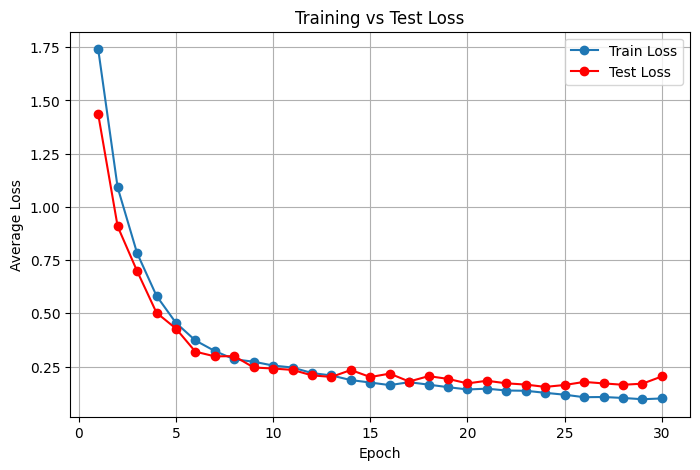

Test Accuracy: 0.9565

 Die ersten N=20 Vorhersagen (N dynamisch anpassbar):

True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
True: Toluene, Predicted: Toluene
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
True: Benzene, Predicted: Benzene
True: Toluene, Predicted: Toluene
True: Acetone, Predicted: Acetone
True: Ammonia, Predicted: Ammonia
True: Ammonia, Predicted: Ammonia
True: Acetone, Predicted: Acetone
True: Benzene, Predicted: Acetone
True: Methane, Predicted: Methane
True: Benzene, Predicted: Benzene
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone


In [17]:
# Training starten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005)
model.to(device)

model.train_model(train_loader, test_loader, epochs=30)
model.evaluate(test_loader)


# Vorhersagen der Gasarten-Namen
gas_labels = ["Ammonia", "Acetone", "Benzene", "Ethylene", "Methane", "Toluene"]

model.eval()

all_preds = [] # Vorhersagen
all_labels = [] # Echte labels

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs, _ = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

classifications = 20
print(f"\n Die ersten N={classifications} Vorhersagen (N dynamisch anpassbar):\n")

for true_idx, pred_idx in zip (all_labels[:classifications], all_preds[:classifications]):
    print(f"True: {gas_labels[true_idx]}, Predicted: {gas_labels[pred_idx]}")


model.save_model("lstm.pth")

Berechneter Threshold: 17.9856



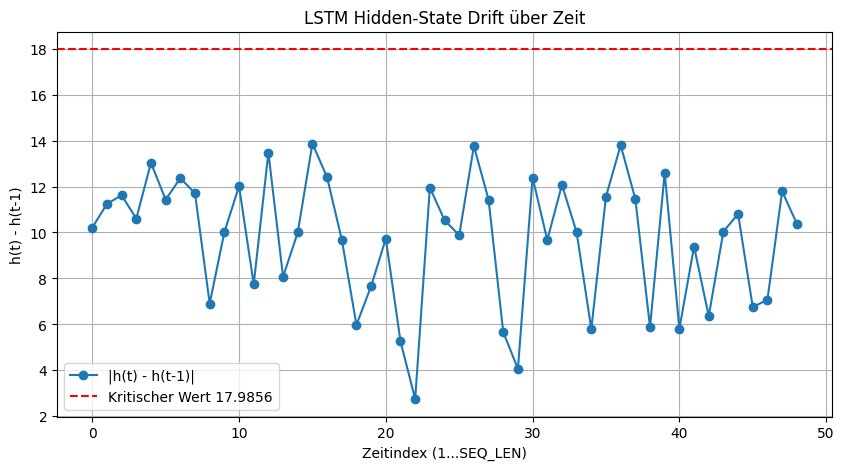


Kein kritisches Verhalten erkannt.


In [18]:
# Hidden-State Driftanalyse
sample_seq = X_test_seq[100]
diffs, critical = analyze_hidden_drift(model, sample_seq, device)

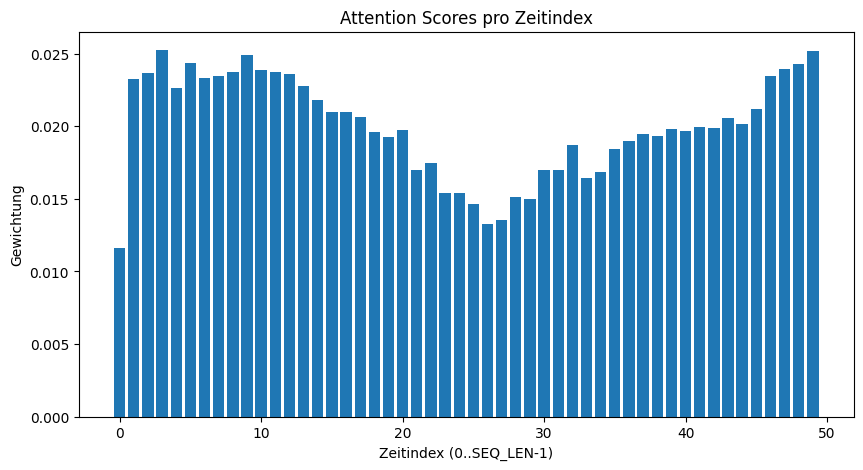

In [19]:
# Attention-Scores Visualisierung
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        _, attn_weights = model(X_batch)
        avg_attn = attn_weights.mean(dim=0).cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.bar(range(len(avg_attn)), avg_attn)
        plt.title("Attention Scores pro Zeitindex")
        plt.xlabel("Zeitindex (0..SEQ_LEN-1)")
        plt.ylabel("Gewichtung")
        plt.show()
        break

Using device: cuda

--- Fold 1/5 ---
Epoch [1/30] | Train Loss: 1.3257 | Test Loss: 1.0516
Epoch [2/30] | Train Loss: 0.9662 | Test Loss: 1.0520
Epoch [3/30] | Train Loss: 0.8314 | Test Loss: 0.7549
Epoch [4/30] | Train Loss: 0.6913 | Test Loss: 1.0161
Epoch [5/30] | Train Loss: 0.5098 | Test Loss: 0.4273
Epoch [6/30] | Train Loss: 0.4500 | Test Loss: 0.3464
Epoch [7/30] | Train Loss: 0.2835 | Test Loss: 0.1942
Epoch [8/30] | Train Loss: 0.2046 | Test Loss: 0.1498
Epoch [9/30] | Train Loss: 0.1952 | Test Loss: 0.1728
Epoch [10/30] | Train Loss: 0.1267 | Test Loss: 0.0971
Epoch [11/30] | Train Loss: 0.1151 | Test Loss: 0.0856
Epoch [12/30] | Train Loss: 0.0799 | Test Loss: 0.0839
Epoch [13/30] | Train Loss: 0.0842 | Test Loss: 0.0760
Epoch [14/30] | Train Loss: 0.0780 | Test Loss: 0.0952
Epoch [15/30] | Train Loss: 0.0786 | Test Loss: 0.0613
Epoch [16/30] | Train Loss: 0.0776 | Test Loss: 0.0636
Epoch [17/30] | Train Loss: 0.0808 | Test Loss: 0.0503
Epoch [18/30] | Train Loss: 0.0574 | 

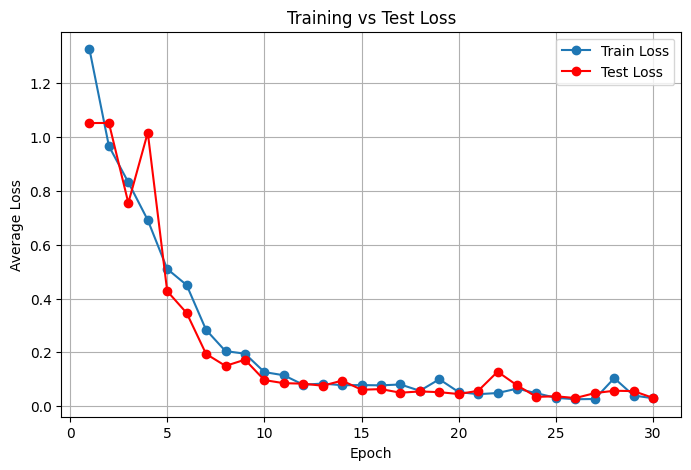

Test Accuracy: 0.9935

--- Fold 2/5 ---
Epoch [1/30] | Train Loss: 1.2597 | Test Loss: 1.0519
Epoch [2/30] | Train Loss: 0.9378 | Test Loss: 0.9648
Epoch [3/30] | Train Loss: 0.7708 | Test Loss: 0.7252
Epoch [4/30] | Train Loss: 0.7107 | Test Loss: 0.6749
Epoch [5/30] | Train Loss: 0.5098 | Test Loss: 0.4335
Epoch [6/30] | Train Loss: 0.3805 | Test Loss: 0.3203
Epoch [7/30] | Train Loss: 0.3211 | Test Loss: 0.2610
Epoch [8/30] | Train Loss: 0.1990 | Test Loss: 0.2781
Epoch [9/30] | Train Loss: 0.1763 | Test Loss: 0.1436
Epoch [10/30] | Train Loss: 0.2979 | Test Loss: 0.1493
Epoch [11/30] | Train Loss: 0.1250 | Test Loss: 0.1351
Epoch [12/30] | Train Loss: 0.0987 | Test Loss: 0.1099
Epoch [13/30] | Train Loss: 0.0914 | Test Loss: 0.1052
Epoch [14/30] | Train Loss: 0.1053 | Test Loss: 0.0839
Epoch [15/30] | Train Loss: 0.1038 | Test Loss: 0.1207
Epoch [16/30] | Train Loss: 0.0687 | Test Loss: 0.1216
Epoch [17/30] | Train Loss: 0.0969 | Test Loss: 0.2326
Epoch [18/30] | Train Loss: 0.0815

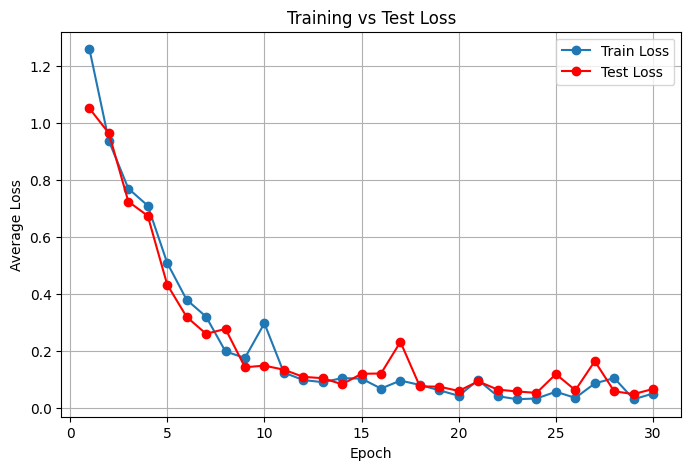

Test Accuracy: 0.9852

--- Fold 3/5 ---
Epoch [1/30] | Train Loss: 1.3262 | Test Loss: 1.1425
Epoch [2/30] | Train Loss: 0.9798 | Test Loss: 0.8478
Epoch [3/30] | Train Loss: 0.8073 | Test Loss: 0.6937
Epoch [4/30] | Train Loss: 0.6245 | Test Loss: 0.4897
Epoch [5/30] | Train Loss: 0.4240 | Test Loss: 0.3862
Epoch [6/30] | Train Loss: 0.3249 | Test Loss: 0.2128
Epoch [7/30] | Train Loss: 0.2144 | Test Loss: 0.1443
Epoch [8/30] | Train Loss: 0.1953 | Test Loss: 0.1529
Epoch [9/30] | Train Loss: 0.1446 | Test Loss: 0.1201
Epoch [10/30] | Train Loss: 0.2750 | Test Loss: 0.1420
Epoch [11/30] | Train Loss: 0.1027 | Test Loss: 0.1673
Epoch [12/30] | Train Loss: 0.0929 | Test Loss: 0.0862
Epoch [13/30] | Train Loss: 0.2031 | Test Loss: 0.2128
Epoch [14/30] | Train Loss: 0.1339 | Test Loss: 0.0763
Epoch [15/30] | Train Loss: 0.0623 | Test Loss: 0.0647
Epoch [16/30] | Train Loss: 0.0668 | Test Loss: 0.0605
Epoch [17/30] | Train Loss: 0.3178 | Test Loss: 0.1527
Epoch [18/30] | Train Loss: 0.0817

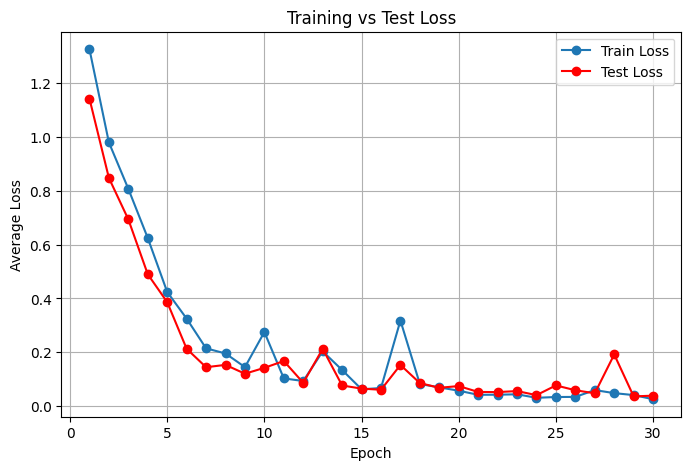

Test Accuracy: 0.9895

--- Fold 4/5 ---
Epoch [1/30] | Train Loss: 1.3272 | Test Loss: 1.0218
Epoch [2/30] | Train Loss: 0.9130 | Test Loss: 0.9773
Epoch [3/30] | Train Loss: 0.8100 | Test Loss: 0.9145
Epoch [4/30] | Train Loss: 0.7292 | Test Loss: 0.6241
Epoch [5/30] | Train Loss: 0.4969 | Test Loss: 0.5088
Epoch [6/30] | Train Loss: 0.3785 | Test Loss: 0.2746
Epoch [7/30] | Train Loss: 0.2591 | Test Loss: 0.2191
Epoch [8/30] | Train Loss: 0.1794 | Test Loss: 0.1487
Epoch [9/30] | Train Loss: 0.1595 | Test Loss: 0.1609
Epoch [10/30] | Train Loss: 0.1195 | Test Loss: 0.1194
Epoch [11/30] | Train Loss: 0.1237 | Test Loss: 0.1068
Epoch [12/30] | Train Loss: 0.0781 | Test Loss: 0.0924
Epoch [13/30] | Train Loss: 0.1298 | Test Loss: 0.2676
Epoch [14/30] | Train Loss: 0.1498 | Test Loss: 0.2725
Epoch [15/30] | Train Loss: 0.0721 | Test Loss: 0.0864
Epoch [16/30] | Train Loss: 0.0562 | Test Loss: 0.0965
Epoch [17/30] | Train Loss: 0.0886 | Test Loss: 0.0867
Epoch [18/30] | Train Loss: 0.0453

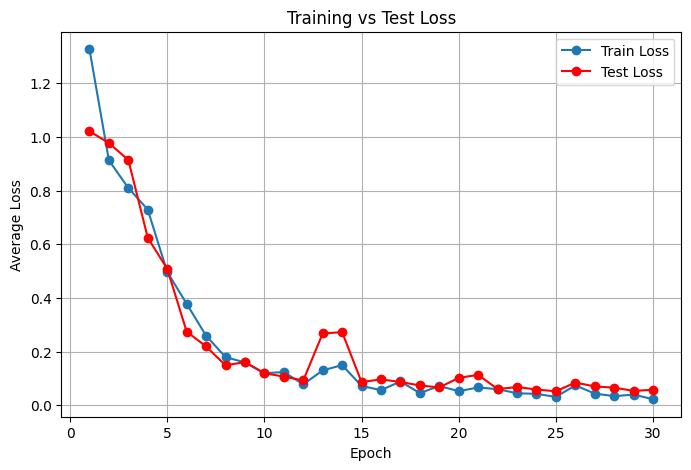

Test Accuracy: 0.9895

--- Fold 5/5 ---
Epoch [1/30] | Train Loss: 1.3234 | Test Loss: 1.0421
Epoch [2/30] | Train Loss: 0.9400 | Test Loss: 0.9272
Epoch [3/30] | Train Loss: 0.7988 | Test Loss: 0.7159
Epoch [4/30] | Train Loss: 0.6621 | Test Loss: 0.5568
Epoch [5/30] | Train Loss: 0.4983 | Test Loss: 0.3522
Epoch [6/30] | Train Loss: 0.3292 | Test Loss: 0.2800
Epoch [7/30] | Train Loss: 0.2942 | Test Loss: 0.2700
Epoch [8/30] | Train Loss: 0.2478 | Test Loss: 0.1402
Epoch [9/30] | Train Loss: 0.1503 | Test Loss: 0.1542
Epoch [10/30] | Train Loss: 0.1644 | Test Loss: 0.1071
Epoch [11/30] | Train Loss: 0.0931 | Test Loss: 0.0806
Epoch [12/30] | Train Loss: 0.1194 | Test Loss: 0.1458


In [ ]:
# 5-Fold Crossvalidation (Bitte Zeit mitnehmen, falls Sie diese Zelle ausführen möchten)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Sequenzen einmal erstellen
X_seq, y_seq = create_sequences(X, y - 1, SEQ_LEN)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Fold-Daten
    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]
    
    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    model = LSTM(input_size=128, hidden_size=256, num_layers=3, num_classes=6, lr=0.0005, dropout=0.5)
    model.to(device)
    
    model.optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    
    model.train_model(train_loader, val_loader, epochs=30)
    
    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Gib den mean der folds aus
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Validation Accuracy across 5 folds: {avg_acc:.4f}")

In [ ]:
# GRID SEARCH (Bereits durchgeführt - nur zur Dokumentation) 
# Beste Parameter: hidden_size=256, num_layers=3

param = {
    "hidden_size": [16, 32, 64, 128, 256],
    "num_layers": [1, 2, 3]
}

param_combi = list(product(
    param["hidden_size"],
    param["num_layers"]
))

results = []

for hidden_size, num_layers in param_combi:
    print(f"\nTesting params: hidden_size={hidden_size}, num_layers={num_layers}")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, num_classes=6, lr=0.0005)
    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(test_loader)
    results.append((hidden_size, num_layers, acc))

best = max(results, key=lambda x: x[-1])
print("\nBeste Hyperparameter-Kombination:", best)